C:\Users\nvleb\AppData\Local\Temp\ipykernel_17220\4272146230.py:112: RuntimeWarning:

Mean of empty slice

C:\Users\nvleb\AppData\Local\Temp\ipykernel_17220\4272146230.py:175: RuntimeWarning:

Mean of empty slice



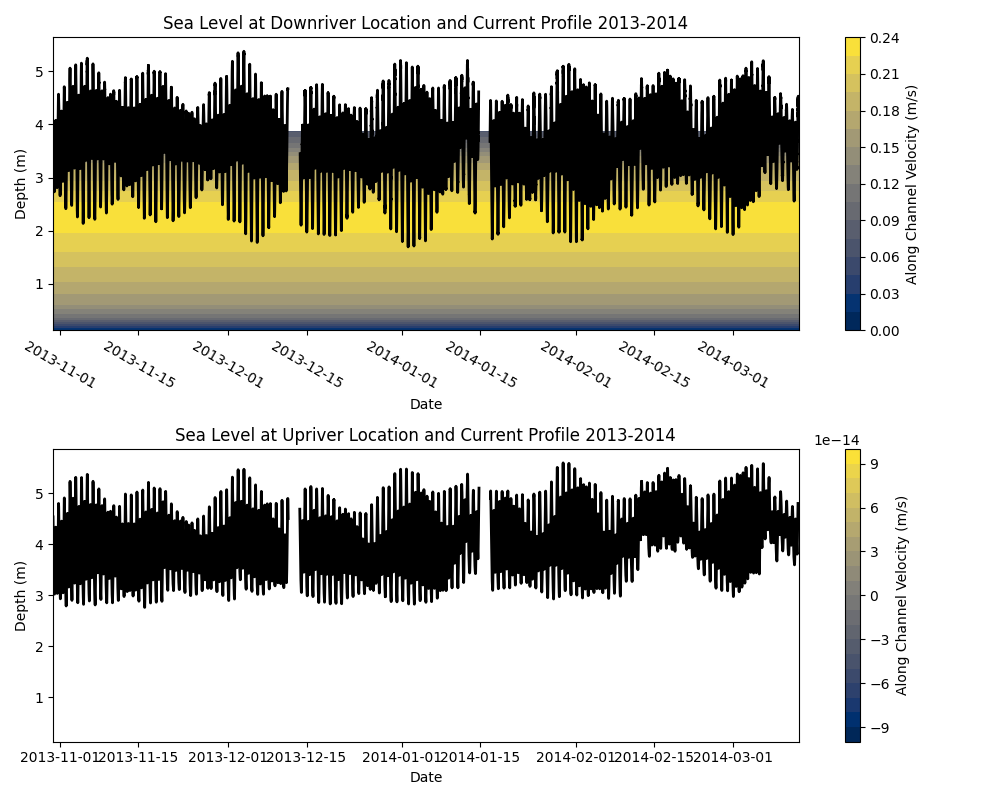

In [3]:
# private dock midestuary
# Data points every 5 minuetes
# HDR is sea level

import pandas as pd
import scipy.io as sio
from scipy import interpolate
import numpy as np
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import re
import json
%matplotlib ipympl

def Array_To_DataFrame(matDF, varName) :
    npArray = np.array([])
    for i in range (matDF[varName].shape[0]) :
        npArray = np.concatenate((npArray, matDF[varName][i].flatten()))
    return npArray
def matFile_To_DF(matFile) :
    tempDF = sio.loadmat(matFile)
    matDataMidFiltered = {}
    for dictKey in tempDF.keys() :
        if isinstance(tempDF[dictKey], np.ndarray) :
            if tempDF[dictKey].shape[0] > 1 :
                matDataMidFiltered.update({dictKey : tempDF[dictKey]})

    matMidDF = pd.DataFrame({dictKey: np.array(dictValue).flatten() for dictKey, dictValue in matDataMidFiltered.items()})
    return matMidDF

def matFileCurrent_To_DF(matFile) :
    tempDF = sio.loadmat(matFile)
    matDataMidFiltered = {}
    for dictKey in tempDF.keys() :
        if isinstance(tempDF[dictKey], np.ndarray) :
            if tempDF[dictKey].shape[0] > 1 and tempDF[dictKey].shape[1] > 1 :
                for i in range(tempDF[dictKey].shape[0]) :
                    matDataMidFiltered.update({dictKey + '_z_' + str(i) : tempDF[dictKey][i]})
            elif dictKey == 'DN':
                matDataMidFiltered.update({dictKey : tempDF[dictKey]})

    matMidDF = pd.DataFrame({dictKey: np.array(dictValue).flatten() for dictKey, dictValue in matDataMidFiltered.items()})
    matMidZ = pd.DataFrame({'z' : tempDF['Z'].flatten()})
    return (matMidDF, matMidZ, tempDF)

# import files for 2012-2013 and extract sea level data
matDockDF = matFile_To_DF('2013_14\\P_processed_01.mat')
# import downriver current data
mainFile = sio.loadmat('UV_SSC_extrap_rotatecurrents.mat')

DN1314 = mainFile['DN1314']
alongChannelVelocityDR = mainFile['UsiR_DR1314']
alongChannelVelocityUR = mainFile['UsiR_UR1314']
depthsDR = mainFile['ZsiDR1314']
depthsUR = mainFile['ZsiUR1314']
seaLevelDR = mainFile['HlDR']
seaLevelUR = mainFile['HlUR']

# create depth range for the buckets splits depths into 20 equal intervals
depthRangeDR = np.linspace(depthsDR.min(), depthsDR.max(), num=depthsDR.shape[0] + 1)
depthBucketsDR = []
# create array with nans to hold same length of the original velocity array
bucketAlongChannelVelocityDR = np.full(alongChannelVelocityDR.shape, np.nan)
# array to count number of velocity arrays in each bucket
bucketVelocityCountDR = np.full(alongChannelVelocityDR.shape, 0)

# loop through each depth range and place velocities in buckets
for i in range(depthRangeDR.shape[0]-1) :
    # mean depth for each bucket
    depthBucketsDR.append((depthRangeDR[i] + depthRangeDR[i+1])/2)
    # go through time values in the along channel velocity array
    for j in range(alongChannelVelocityDR.shape[1]) :
        # go through depth values to find which bucket
        for k in range(alongChannelVelocityDR.shape[0]) :
            # if depth at that point is in the current bucket range add to bucket
            if depthsDR[k][j] >= depthRangeDR[i] and depthsDR[k][j] < depthRangeDR[i+1] :
                # if value is nan, gives it the along channel velocity value
                if np.isnan(bucketAlongChannelVelocityDR[i][j]) :
                    bucketAlongChannelVelocityDR[i][j] = alongChannelVelocityDR[k][j]
                    bucketVelocityCountDR[i][j] = 1
                # if value is not nan, adds to existing value
                else :
                    bucketAlongChannelVelocityDR[i][j] = bucketAlongChannelVelocityDR[i][j] + np.nan_to_num(alongChannelVelocityDR[k][j])
                    bucketVelocityCountDR[i][j] += 1
# divide by number of values in each bucket to get mean
for i in range(bucketAlongChannelVelocityDR.shape[0]) :
    for j in range(bucketAlongChannelVelocityDR.shape[1]) :
        if bucketVelocityCountDR[i,j] > 0 :
            bucketAlongChannelVelocityDR[i,j] = bucketAlongChannelVelocityDR[i,j] / bucketVelocityCountDR[i,j]

seaLevel = mainFile['HlDR']
ADCPDict = {'DN' : DN1314.flatten(), 'U' : bucketAlongChannelVelocityDR, 'Z' : depthBucketsDR + abs(depthRangeDR[0]), 'H' : seaLevel.flatten()}
# resize U array to match matDockDF DN length
ADCPDictUResized = np.resize(ADCPDict['U'], (ADCPDict['U'].shape[0], 38311))

for i in range(ADCPDict['U'].shape[0]) :
    # interpolate each depth level to match matDockDF DN values
    tempNp = np.interp(matDockDF['DN'], ADCPDict['DN'].flatten(), ADCPDict['U'][i])
    ADCPDictUResized[i] = tempNp
#mat lab date origin
origin = np.datetime64('0000-01-01', 'D') - np.timedelta64(1, 'D')
#convert DN to datetime
matDockDF['DN'] = (matDockDF['DN'] * np.timedelta64(24*3600000, 'ms') + origin + np.timedelta64(500, 'ms')).astype('datetime64[s]')
ADCPDict['DN'] = (ADCPDict['DN'] * np.timedelta64(24*3600000, 'ms') + origin + np.timedelta64(500, 'ms')).astype('datetime64[s]')

# CALCULATION OF DEPTH AVERAGED VELOCITY FOR DOWNRIVER SITE du/dz
downriverDepthAveragedVelocity = np.full(ADCPDictUResized.shape[1], np.nan)
for j in range(ADCPDictUResized.shape[1]) :
    downriverDepthAveragedVelocity[j] = np.nanmean(ADCPDictUResized[:,j])
ADCPDict['DepthAveragedU13_14'] = downriverDepthAveragedVelocity    

# UPRIVER

# create depth range for the buckets splits depths into 20 equal intervals
depthRangeUR = np.linspace(depthsUR.min(), depthsUR.max(), num=depthsUR.shape[0] + 1)
depthBucketsUR = []
# create array with nans to hold same length of the original velocity array
bucketAlongChannelVelocityUR = np.full(alongChannelVelocityUR.shape, np.nan)
# array to count number of velocity arrays in each bucket
bucketVelocityCountUR = np.full(alongChannelVelocityUR.shape, 0)

# loop through each depth range and place velocities in buckets
for i in range(depthRangeUR.shape[0]-1) :
    # mean depth for each bucket
    depthBucketsUR.append((depthRangeUR[i] + depthRangeUR[i+1])/2)
    # go through time values in the along channel velocity array
    for j in range(alongChannelVelocityUR.shape[1]) :
        # go through depth values to find which bucket
        for k in range(alongChannelVelocityUR.shape[0]) :
            # if depth at that point is in the current bucket range add to bucket
            if depthsUR[k][j] >= depthRangeUR[i] and depthsDR[k][j] < depthRangeUR[i+1] :
                # if value is nan, gives it the along channel velocity value
                if np.isnan(bucketAlongChannelVelocityUR[i][j]) :
                    bucketAlongChannelVelocityUR[i][j] = alongChannelVelocityUR[k][j]
                    bucketVelocityCountUR[i][j] = 1
                # if value is not nan, adds to existing value
                else :
                    bucketAlongChannelVelocityUR[i][j] = bucketAlongChannelVelocityUR[i][j] + np.nan_to_num(alongChannelVelocityUR[k][j])
                    bucketVelocityCountUR[i][j] += 1
# divide by number of values in each bucket to get mean
for i in range(bucketAlongChannelVelocityUR.shape[0]) :
    for j in range(bucketAlongChannelVelocityUR.shape[1]) :
        if bucketVelocityCountUR[i,j] > 0 :
            bucketAlongChannelVelocityUR[i,j] = bucketAlongChannelVelocityUR[i,j] / bucketVelocityCountUR[i,j]

seaLevel = mainFile['HlDR']
ADCPDict = {'DN' : DN1314.flatten(), 'U' : bucketAlongChannelVelocityDR, 'Z' : depthBucketsDR + abs(depthRangeDR[0]), 'H' : seaLevel.flatten()}
AquadoppDict = {'DN' : DN1314.flatten(), 'U' : bucketAlongChannelVelocityUR, 'Z' : depthBucketsUR + abs(depthRangeUR[0]), 'H' : seaLevel.flatten()}
# resize U array to match matDockDF DN length
ADCPDictUResized = np.resize(ADCPDict['U'], (ADCPDict['U'].shape[0], 38311))
AquadoppDictUResized = np.resize(AquadoppDict['U'], (AquadoppDict['U'].shape[0], 38311))

for i in range(ADCPDict['U'].shape[0]) :
    # interpolate each depth level to match matDockDF DN values
    tempNp = np.interp(matDockDF['DN'], ADCPDict['DN'].flatten(), ADCPDict['U'][i])
    ADCPDictUResized[i] = tempNp
for i in range(AquadoppDict['U'].shape[0]) :
    # interpolate each depth level to match matDockDF DN values
    tempNp = np.interp(matDockDF['DN'], AquadoppDict['DN'].flatten(), AquadoppDict['U'][i])
    AquadoppDictUResized[i] = tempNp
#mat lab date origin
AquadoppDict['DN'] = (AquadoppDict['DN'] * np.timedelta64(24*3600000, 'ms') + origin + np.timedelta64(500, 'ms')).astype('datetime64[s]')

# CALCULATION OF DEPTH AVERAGED VELOCITY FOR DOWNRIVER SITE du/dz
downriverDepthAveragedVelocity = np.full(ADCPDictUResized.shape[1], np.nan)
for j in range(ADCPDictUResized.shape[1]) :
    downriverDepthAveragedVelocity[j] = np.nanmean(ADCPDictUResized[:,j])
ADCPDict['DepthAveragedU13_14'] = downriverDepthAveragedVelocity    
# CALCULATION OF DEPTH AVERAGED VELOCITY FOR UPRIVER SITE du/dz
upriverDepthAveragedVelocity = np.full(AquadoppDictUResized.shape[1], np.nan)
for j in range(AquadoppDictUResized.shape[1]) :
    upriverDepthAveragedVelocity[j] = np.nanmean(AquadoppDictUResized[:,j])
AquadoppDict['DepthAveragedU13_14'] = upriverDepthAveragedVelocity

depthAvgfig = px.line(x = matDockDF['DN'], y = [ADCPDict['DepthAveragedU13_14']], color_discrete_sequence= ["black"], title = "Depth Averaged Velocity Downriver 2013-2014")
depthAvgFigLabel = ['Downriver Depth Averaged Velocity']
for idx in range(len(depthAvgFigLabel)):
    depthAvgfig.data[idx].name = depthAvgFigLabel[idx]
    depthAvgfig.data[idx].hovertemplate = 'variable=' + depthAvgFigLabel[idx] + '<br>x=%{x}<br>value=%{y}<extra></extra>'
    depthAvgfig.data[idx].legendgroup = depthAvgFigLabel[idx]


depthAvgfig.update_layout(title=dict(text= "Depth Averaged Velocity for 2013-2014", font=dict(size=25)))
depthAvgfig.update_xaxes(tickangle=30)
depthAvgfig.update_xaxes(rangeslider_visible=True)
depthAvgfig.update_xaxes(range = [pd.Timestamp('2013-10-28'),pd.Timestamp('2014-03-17')])
depthAvgfig.update_layout(xaxis_title="Date", yaxis_title="Depth Averaged Velocity (m/s)", legend_title="Locations")
depthAvgfig.show()



fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
plt.subplots_adjust(hspace=3)
contourPlot = ax1.contourf(matDockDF['DN'], (ADCPDict['Z']), ADCPDictUResized, levels = len(ADCPDict['Z']), cmap = 'cividis')
fig.colorbar(contourPlot, ax = ax1, label = 'Along Channel Velocity (m/s)')
ax1.plot(matDockDF['DN'], matDockDF['Hdr'], linewidth=2, label='SeaLevel at Downriver Location', color = 'black')
ax1.set_title('Sea Level at Downriver Location and Current Profile 2013-2014')
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (m)')
ax1.set_xlim([matDockDF['DN'].min(), matDockDF['DN'].max()])
ax1.tick_params('x', rotation = -30)

contourPlot2 = ax2.contourf(matDockDF['DN'], (AquadoppDict['Z']), AquadoppDictUResized, levels = len(AquadoppDict['Z']), cmap = 'cividis')
fig.colorbar(contourPlot2, ax = ax2, label = 'Along Channel Velocity (m/s)')
ax2.plot(matDockDF['DN'], matDockDF['Hur'], linewidth=2, label='SeaLevel at Upriver Location', color = 'black')
ax2.set_title('Sea Level at Upriver Location and Current Profile 2013-2014')
ax2.set_xlabel('Date')
ax2.set_ylabel('Depth (m)')


plt.tight_layout()
plt.show()